# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [1]:
import logging
import requests
import re

import sys
import joblib
import os
# from dotenv import load_dotenv
import boto3
from urllib.parse import urlparse

import matplotlib.pyplot as plt

import numpy as np
import scipy
import pandas as pd

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, normalize
from sklearn.metrics import mean_squared_error, mean_absolute_error, ndcg_score
from sklearn.metrics.pairwise import cosine_similarity

from surprise import Dataset, Reader, SVD, NormalPredictor, accuracy

from implicit.als import AlternatingLeastSquares

from catboost import CatBoostClassifier, Pool

# Suppress warnings
import warnings

In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

In [4]:
# Параметры загрузки в storage
endpoint_url = os.environ.get('ENDPOINT_URL')
bucket_name = os.environ.get('S3_BUCKET_NAME')
url = f's3://{bucket_name}'

In [5]:
os.makedirs('data', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('recommendations', exist_ok=True)

# === ЭТАП 1 ===

# Загрузка первичных данных

In [ ]:
initial_df = pd.read_csv("./data/initial_data.csv")

# Обзор данных

In [6]:
print(initial_df.info())
display(initial_df.head())
print(initial_df.isna().sum())
# print(initial_df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13647309 entries, 0 to 13647308
Data columns (total 48 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   fecha_dato             object 
 1   ncodpers               int64  
 2   ind_empleado           object 
 3   pais_residencia        object 
 4   sexo                   object 
 5   age                    object 
 6   fecha_alta             object 
 7   ind_nuevo              float64
 8   antiguedad             object 
 9   indrel                 float64
 10  ult_fec_cli_1t         object 
 11  indrel_1mes            object 
 12  tiprel_1mes            object 
 13  indresi                object 
 14  indext                 object 
 15  conyuemp               object 
 16  canal_entrada          object 
 17  indfall                object 
 18  tipodom                float64
 19  cod_prov               float64
 20  nomprov                object 
 21  ind_actividad_cliente  float64
 22  renta           

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0.0,6,1.0,NaN,1.0,A,S,N,NaN,KHL,N,1.0,29.0,MALAGA,1.0,87218.10,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,S,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,35548.74,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,N,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,122179.11,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,N,NaN,KHD,N,1.0,50.0,ZARAGOZA,0.0,119775.54,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,A,S,N,NaN,KHE,N,1.0,50.0,ZARAGOZA,1.0,NaN,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0


fecha_dato                      0
ncodpers                        0
ind_empleado                27734
pais_residencia             27734
sexo                        27804
age                             0
fecha_alta                  27734
ind_nuevo                   27734
antiguedad                      0
indrel                      27734
ult_fec_cli_1t           13622516
indrel_1mes                149781
tiprel_1mes                149781
indresi                     27734
indext                      27734
conyuemp                 13645501
canal_entrada              186126
indfall                     27734
tipodom                     27735
cod_prov                    93591
nomprov                     93591
ind_actividad_cliente       27734
renta                     2794375
segmento                   189368
ind_ahor_fin_ult1               0
ind_aval_fin_ult1               0
ind_cco_fin_ult1                0
ind_cder_fin_ult1               0
ind_cno_fin_ult1                0
ind_ctju_fin_u

In [7]:
# Изменим типы данных в столбцах в соответствии с их содержанием

# Временные признаки
for cols in ['fecha_dato', 'fecha_alta', 'ult_fec_cli_1t']:
    initial_df[cols] = pd.to_datetime(initial_df[cols])

# Числовые признаки
for cols in ['age', 'antiguedad']:
    initial_df[cols] = pd.to_numeric(initial_df[cols], errors='coerce')

In [8]:
initial_df.columns

Index(['fecha_dato', 'ncodpers', 'ind_empleado', 'pais_residencia', 'sexo',
       'age', 'fecha_alta', 'ind_nuevo', 'antiguedad', 'indrel',
       'ult_fec_cli_1t', 'indrel_1mes', 'tiprel_1mes', 'indresi', 'indext',
       'conyuemp', 'canal_entrada', 'indfall', 'tipodom', 'cod_prov',
       'nomprov', 'ind_actividad_cliente', 'renta', 'segmento',
       'ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1',
       'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
       'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1',
       'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
       'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1',
       'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
       'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1',
       'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1'],
      dtype='object')

In [9]:
client_features = ['ind_empleado', 'pais_residencia', 'sexo',
       'age', 'fecha_alta', 'ind_nuevo', 'antiguedad', 'indrel',
       'ult_fec_cli_1t', 'indrel_1mes', 'tiprel_1mes', 'indresi', 'indext',
       'conyuemp', 'canal_entrada', 'indfall', 'tipodom', 'cod_prov',
       'nomprov', 'ind_actividad_cliente', 'renta', 'segmento']

In [11]:
cat_features = initial_df.select_dtypes(include='object')
unique_values_per_col = cat_features.nunique(dropna=False)
unique_values_per_col

ind_empleado         6
pais_residencia    119
sexo                 3
indrel_1mes         14
tiprel_1mes          6
indresi              3
indext               3
conyuemp             3
canal_entrada      163
indfall              3
nomprov             53
segmento             4
dtype: int64

In [12]:
print(initial_df['pais_residencia'].value_counts(dropna=False))
print(initial_df['indrel_1mes'].value_counts(dropna=False))
print(initial_df['tiprel_1mes'].value_counts(dropna=False))
print(initial_df['canal_entrada'].value_counts(dropna=False))
print(initial_df['nomprov'].value_counts(dropna=False))

pais_residencia
ES     13553710
NaN       27734
FR         5161
AR         4835
DE         4625
GB         4605
US         3651
CO         3526
IT         2947
RO         2931
MX         2573
BR         2351
VE         2331
EC         2169
CH         1995
BE         1526
BO         1514
PY         1430
PT         1419
CL          989
PE          900
RU          769
CU          758
NL          757
SE          603
PL          599
CN          563
UY          510
UA          493
AT          476
BG          476
CA          446
AU          424
DO          424
IL          413
IE          409
MA          396
FI          345
HN          282
GR          243
JP          239
DK          226
AE          221
NG          214
IN          187
CR          147
NO          136
GT          130
LU          124
ZA          119
GQ          119
SG          117
AD          111
BY          102
TH          102
SV          102
CZ          102
PR          101
KR           96
MD           96
DZ           86
PK      

In [13]:
# Столбец 'indrel_1mes' содержит разные обозначения одних и тех же категорий. Необходимо устранить разнообразие.

initial_df['indrel_1mes'] = initial_df['indrel_1mes'].replace('P', '5')
initial_df['indrel_1mes'] = pd.to_numeric(initial_df['indrel_1mes'], errors='raise')
print(initial_df['indrel_1mes'].value_counts(dropna=False))

indrel_1mes
1.0    13490681
NaN      149781
3.0        4350
2.0        1317
5.0         874
4.0         306
Name: count, dtype: int64


Ряд признаков содержат большое количество маленьких категорий. Маленькой будем считать категории с количеством записей менее 100000, хотя это вопрос спорный. Объединим категории с количеством записей менее 100000 в одну - 'other'.

In [14]:
%%script false --no-raise-error

for feat in ['pais_residencia', 'canal_entrada', 'nomprov']:
    cat_frequency = initial_df[feat].value_counts()
    small_cat = cat_frequency[cat_frequency < 100000].index
    initial_df.loc[initial_df[feat].isin(small_cat), feat] = 'other'

In [15]:
# Стало
unique_values_per_col = cat_features.nunique(dropna=False)
unique_values_per_col

ind_empleado         6
pais_residencia    119
sexo                 3
indrel_1mes         14
tiprel_1mes          6
indresi              3
indext               3
conyuemp             3
canal_entrada      163
indfall              3
nomprov             53
segmento             4
dtype: int64

# Exit

In [16]:
# Временной интервал, в рамках которого рассматриваем потребительское поведение
print(initial_df['fecha_dato'].min())
print(initial_df['fecha_dato'].max())

2015-01-28 00:00:00
2016-05-28 00:00:00


In [17]:
# Временной интервал, в рамках были заключены клиентские договоры
print(initial_df['fecha_alta'].min())
print(initial_df['fecha_alta'].max())

1995-01-16 00:00:00
2016-05-31 00:00:00


In [18]:
# Количество клиентов
print(initial_df['ncodpers'].nunique())

956645


In [19]:
# Заменяем дату, когда клиент впервые заключил договор в банке, на последний день месяца
initial_df['started_at_month'] = initial_df['fecha_alta'].dt.to_period('M').dt.end_time.dt.date
interactions_by_month = initial_df.groupby("started_at_month").agg(new_clients_count=("fecha_alta", "count")).reset_index()

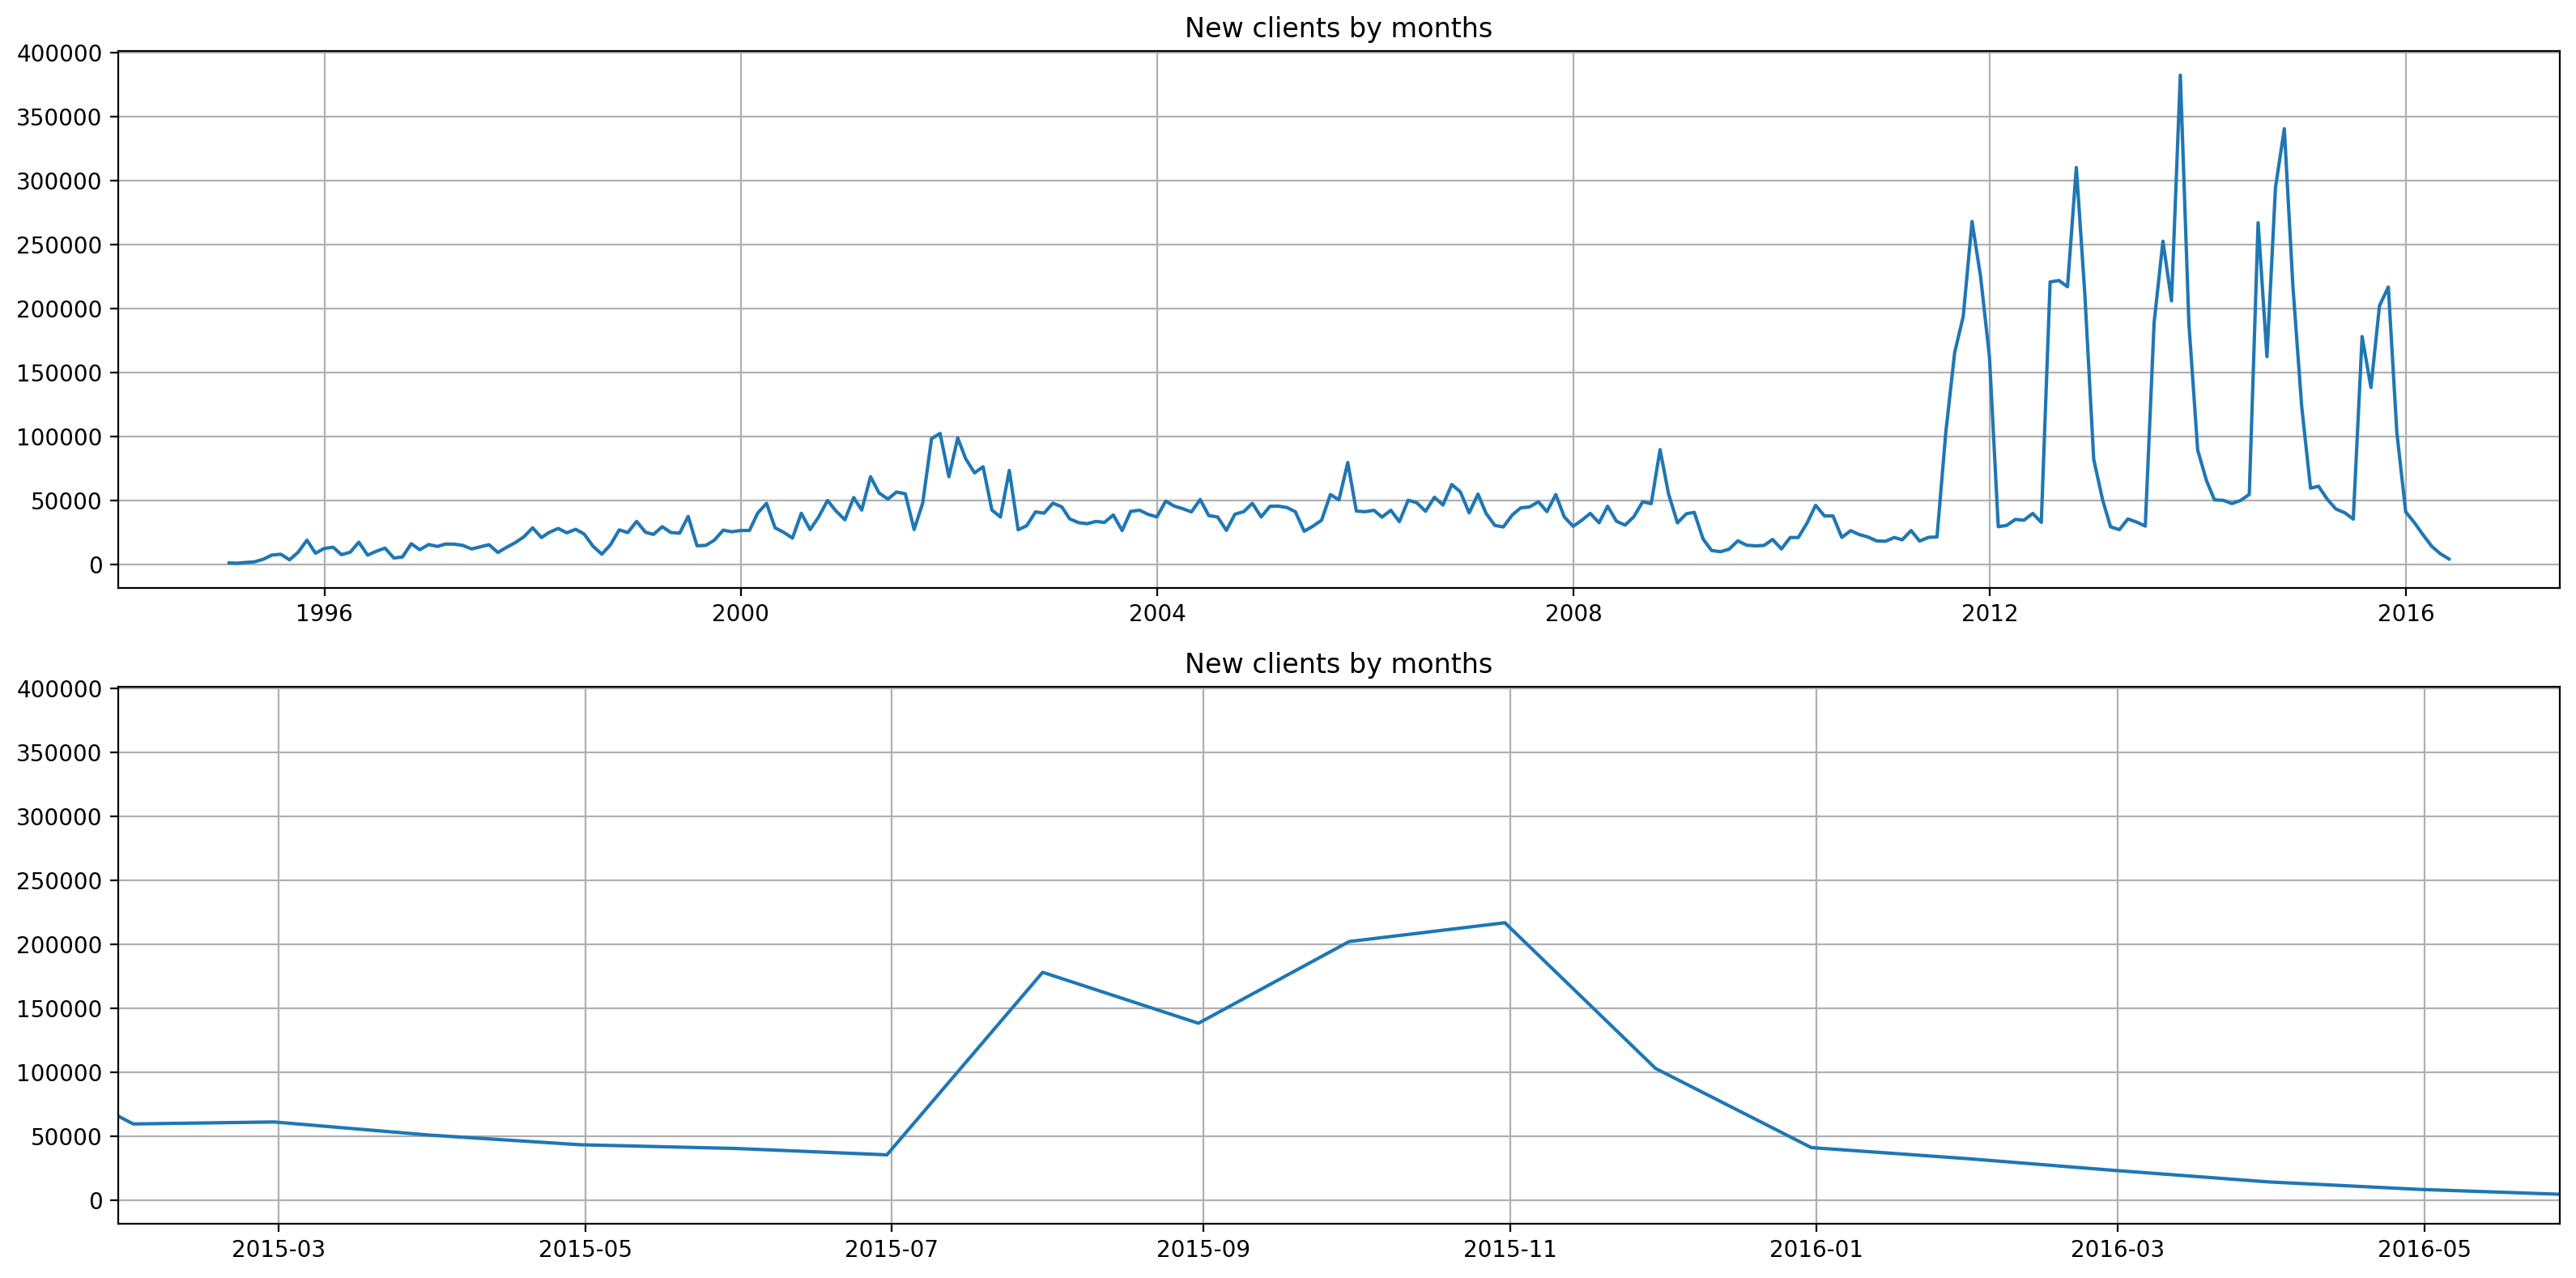

In [20]:
# распределение взаимодействий по месяцам

fig, axs = plt.subplots(2, 1, figsize=(16, 8))

for i in range(2):
    axs[i].plot(interactions_by_month["started_at_month"], interactions_by_month["new_clients_count"])
    axs[i].grid()
    axs[i].set_title("New clients by months")

axs[1].set_xlim(initial_df['fecha_dato'].min(), 
            initial_df['fecha_dato'].max())

fig.tight_layout()

In [21]:
print(initial_df['fecha_dato'].value_counts())

fecha_dato
2016-05-28    931453
2016-04-28    928274
2016-03-28    925076
2016-02-28    920904
2016-01-28    916269
2015-12-28    912021
2015-11-28    906109
2015-10-28    892251
2015-09-28    865440
2015-08-28    843201
2015-07-28    829817
2015-06-28    632110
2015-05-28    631957
2015-04-28    630367
2015-03-28    629209
2015-02-28    627394
2015-01-28    625457
Name: count, dtype: int64


In [22]:
client_features

['ind_empleado',
 'pais_residencia',
 'sexo',
 'age',
 'fecha_alta',
 'ind_nuevo',
 'antiguedad',
 'indrel',
 'ult_fec_cli_1t',
 'indrel_1mes',
 'tiprel_1mes',
 'indresi',
 'indext',
 'conyuemp',
 'canal_entrada',
 'indfall',
 'tipodom',
 'cod_prov',
 'nomprov',
 'ind_actividad_cliente',
 'renta',
 'segmento']

In [23]:
display(initial_df[initial_df[client_features].isna().all(axis=1)].head())

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1,started_at_month
261,2015-01-28,1050741,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,NaT
1029,2015-01-28,1051017,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,NaT
1063,2015-01-28,1051064,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,NaT
1154,2015-01-28,1051387,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,NaT
1779,2015-01-28,1048660,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,NaT


Есть группа клиентов, для которых неизвестны значения клиентских признаков. Оценим их количество и количество связанных с ними событий.

In [24]:
display(initial_df[initial_df[client_features].isna().all(axis=1)]['ncodpers'].nunique())
display(initial_df[initial_df[client_features].isna().all(axis=1)].shape[0])


7340

27734

In [ ]:
display(initial_df[initial_df[client_features].isna().all(axis=1)][items_list].nunique())

ind_ahor_fin_ult1    1
ind_aval_fin_ult1    1
ind_cco_fin_ult1     2
ind_cder_fin_ult1    2
ind_cno_fin_ult1     2
ind_ctju_fin_ult1    2
ind_ctma_fin_ult1    2
ind_ctop_fin_ult1    2
ind_ctpp_fin_ult1    2
ind_deco_fin_ult1    2
ind_deme_fin_ult1    2
ind_dela_fin_ult1    2
ind_ecue_fin_ult1    2
ind_fond_fin_ult1    2
ind_hip_fin_ult1     2
ind_plan_fin_ult1    2
ind_pres_fin_ult1    2
ind_reca_fin_ult1    2
ind_tjcr_fin_ult1    2
ind_valo_fin_ult1    2
ind_viv_fin_ult1     2
ind_nomina_ult1      2
ind_nom_pens_ult1    2
ind_recibo_ult1      2
dtype: int64

# Выводы

- tracks.parquet содержит таблицу со списками в ячейках столбцов 'albums', 'artists',	'genres'. Для дальнейшего анализа неоходимо "развернуть" списки в столбцах DataFrame методом explode().
- После "разворачивания" списков появились строки с NaN, доля которых составляет около 1% от вcего объёма выборки.
- В таблицах файлов catalog_names.parquet и interactions.parquet пропуски и полные дубликаты отсутствуют.

# === ЭТАП 2 ===

# EDA

## Распределение количества прослушанных треков.

In [14]:
interactions["started_at_month"] = pd.to_datetime(interactions["started_at"]).dt.to_period('M').dt.start_time.dt.date

In [15]:
interactions_by_month = interactions.groupby("started_at_month").agg(events=("started_at", "count")).reset_index()

In [16]:
interactions_by_month.head()

,started_at_month,events
0,2022-01-01,2409541
1,2022-02-01,4533363
2,2022-03-01,7691225
3,2022-04-01,10230295
4,2022-05-01,13613489


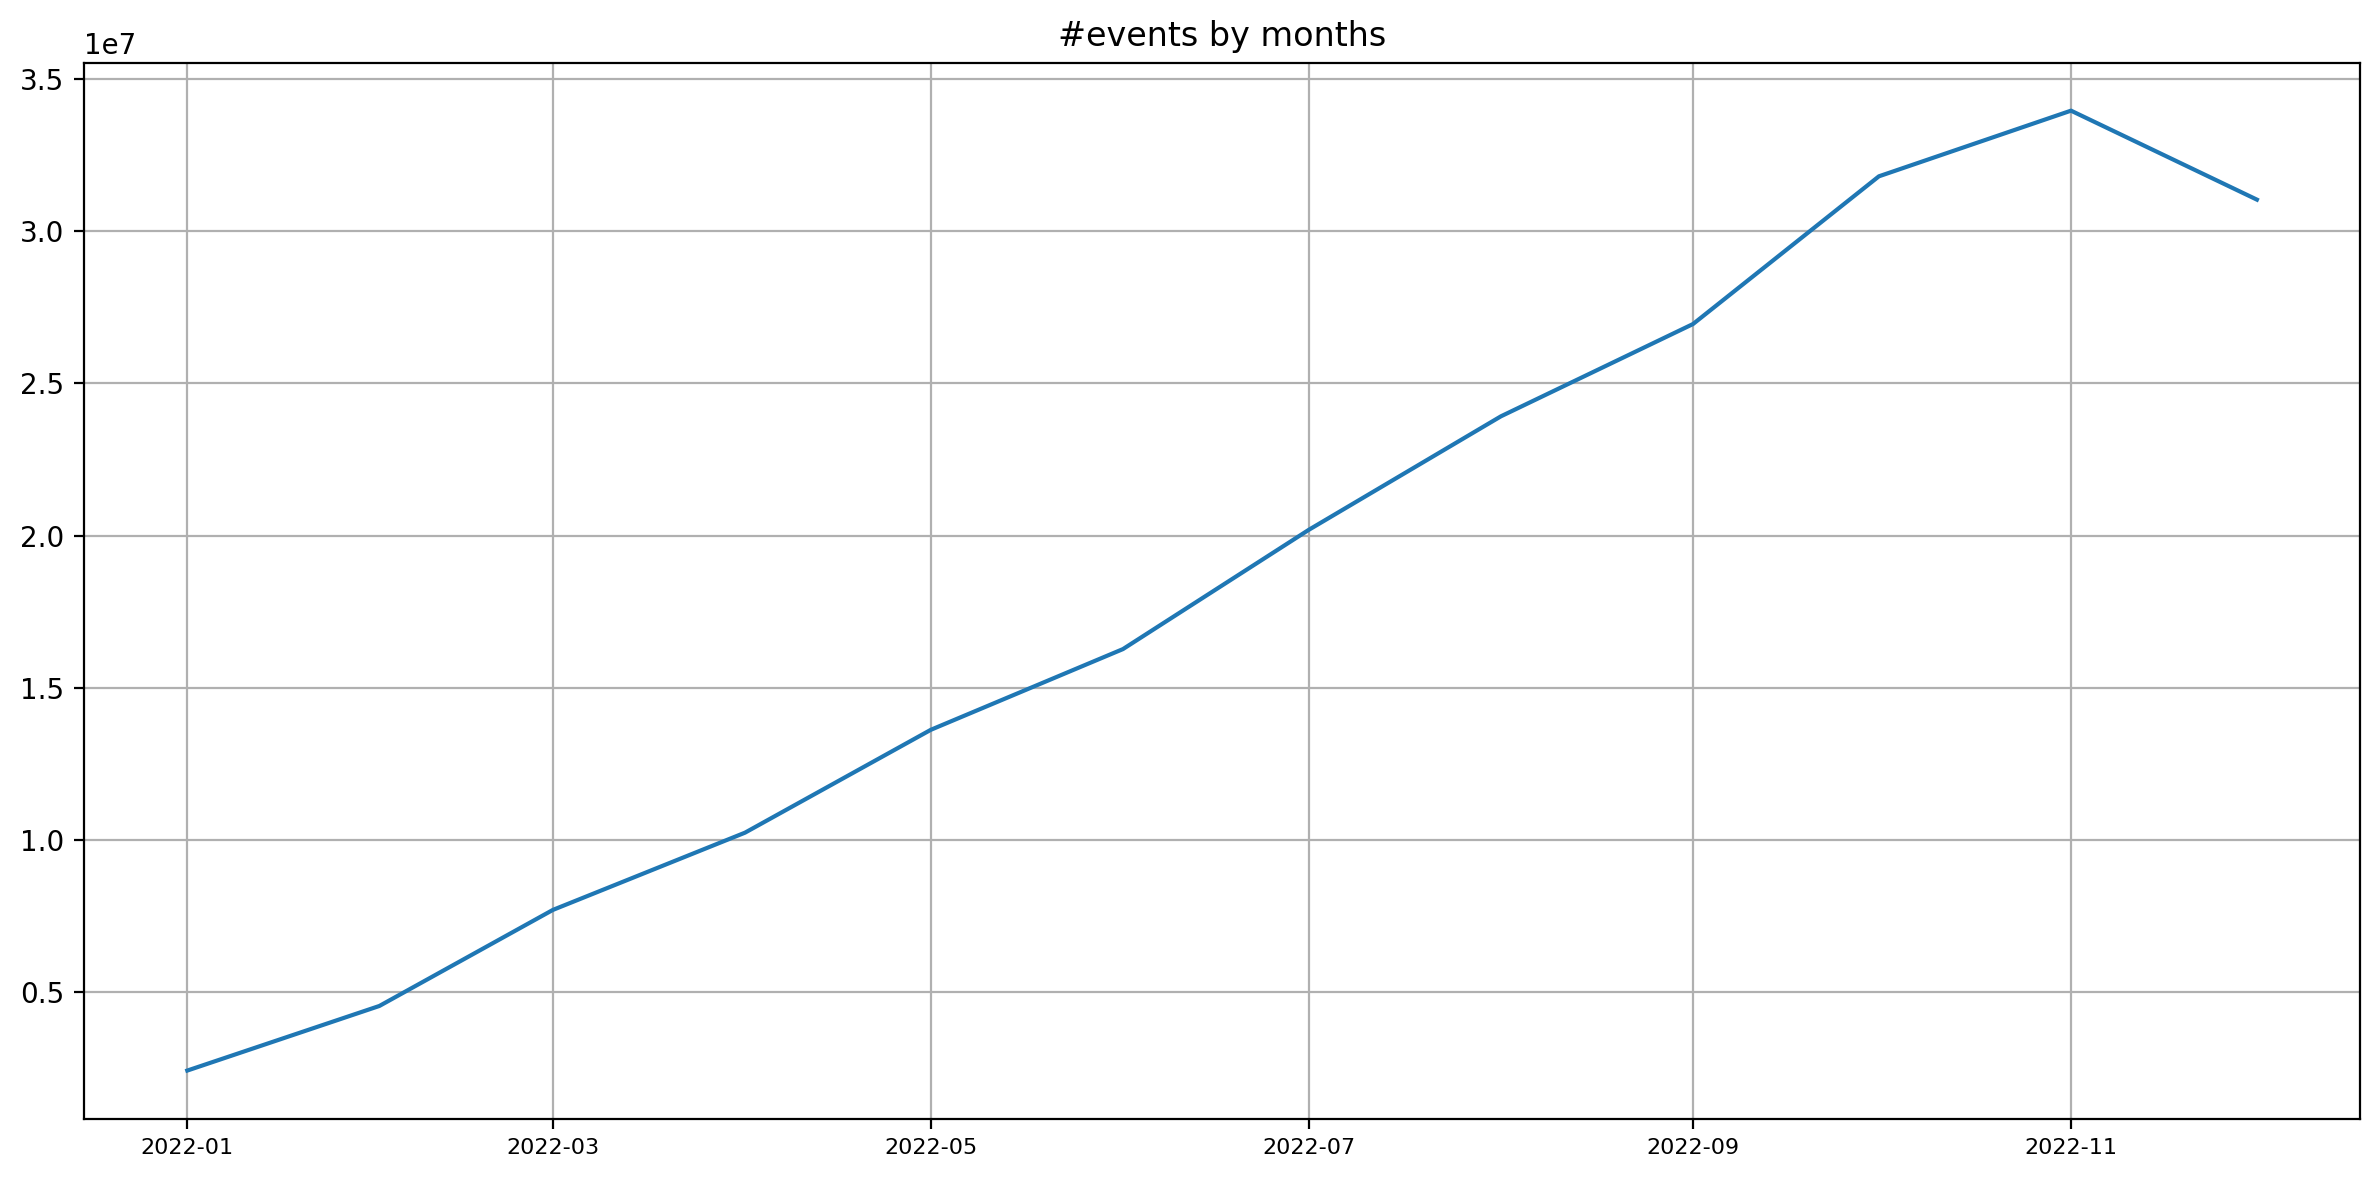

In [17]:
# распределение взаимодействий по месяцам

fig, axs = plt.subplots(1, 1, figsize=(12, 6))

ax = axs
ax.plot(interactions_by_month["started_at_month"], interactions_by_month["events"])
ax.tick_params(axis='x', labelsize=8)
ax.grid()
ax.set_title("#events by months")

fig.tight_layout()

## Наиболее популярные треки (ТОП-10)

In [18]:
popular_tracks = interactions['track_id'].value_counts()
popular_tracks[:10]

track_id
53404       111062
33311009    106921
178529      101924
35505245     99490
65851540     86670
24692821     86246
32947997     85886
51241318     85244
795836       85042
45499814     84748
Name: count, dtype: int64

## Наиболее популярные жанры (ТОП-10)

In [19]:
genres_popularity_df = (tracks[['track_id', 'genres']].drop_duplicates(keep='last')
                                                      .merge(popular_tracks, 
                                                             left_on='track_id', 
                                                             right_index=True))

In [20]:
# Проверка
genres_popularity_df[genres_popularity_df['track_id']==53404]

,track_id,genres,count
9098,53404,13,111062
9098,53404,14,111062
9098,53404,102,111062


In [21]:
popular_genres = genres_popularity_df.groupby('genres')['count'].sum().sort_values(ascending=False)
popular_genres[:10]

genres
11     55578312
75     37799821
102    31092013
20     26626241
3      25303695
68     20120981
16     16291557
2      13166147
14     12772644
47     12437375
Name: count, dtype: int64

## Треки, которые никто не прослушал

In [22]:
list(set(tracks['track_id']) - set(interactions['track_id']))

[]

# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

In [15]:
print(tracks.isna().sum())

track_id        0
albums         18
artists     41789
genres      36675
dtype: int64


In [ ]:
# Переименование столбцов
tracks = tracks.rename(columns={'albums': 'album_id',
                                'artists': 'artist_id',
                                'genres': 'genre_id',                                
                                }) 

In [ ]:
# Присоединяем названия
for i in ['track', 'album', 'artist', 'genre']:
    tracks = (tracks.merge(catalog_names[catalog_names['type'] == i][['id', 'name']].set_index('id'), 
                           left_on=f'{i}_id',
                           right_index=True,
                           how='left')
                     .rename(columns={'name': i}))
tracks.reset_index(drop=True, inplace=True)

In [ ]:
# Проверка
print(tracks.isna().sum())

track_id          0
album_id         18
artist_id     41789
genre_id      36675
track             0
album            18
artist        41789
genre        230279
dtype: int64


<mark>Вывод.</mark> Количество пропусков в столбце genre_id БОЛЬШЕ количества пропусков в соответствующем столбце genre. Это говорит о том, что часть идентификаторов жанров "пустые", т.е. не имеют названий. См. пример ниже.

In [ ]:
tracks[tracks['genre_id'].notna() & tracks['genre'].isna()].head()

,track_id,album_id,artist_id,genre_id,track,album,artist,genre
191,436,36,330,164,A Secret Place,A Secret Place,"Grover Washington, Jr.",NaN
1445,594,54,533,162,Peace Piece,"Sides Of Blue, Vol. 2",Bill Evans,NaN
1447,594,88,533,162,Peace Piece,Jazz Six Pack,Bill Evans,NaN
1449,594,5479,533,162,Peace Piece,Everybody Digs Bill Evans,Bill Evans,NaN
1451,594,5785124,533,162,Peace Piece,The Definitive Bill Evans on Riverside and Fan...,Bill Evans,NaN


In [ ]:
# Заменим "пустые" genre_id на NaN
tracks.loc[tracks['genre_id'].notna() & tracks['genre'].isna(), 'genre_id'] = np.nan

In [ ]:
# Проверка
print(tracks.isna().sum())

track_id          0
album_id         18
artist_id     41789
genre_id     230279
track             0
album            18
artist        41789
genre        230279
dtype: int64


<mark>Вывод.</mark> Теперь количество пропусков в столбцах с id РАВНО количеству пропусков в соответствующих столбцах с названиями.

In [ ]:
tracks.drop(columns=['album_id', 'artist_id', 'genre_id'], inplace=True)

# "Схлопываем" DF, удаляя пропуски и дубликаты в каждом столбце группы
tracks = tracks.groupby(by=['track_id', 'track']).agg(lambda x: x.dropna().drop_duplicates(keep='last').to_list()).reset_index()

In [ ]:
tracks = tracks.rename(columns={'track_id': 'item_id', 'track': 'title'})
interactions = interactions.rename(columns={'track_id': 'item_id', 'track_seq': 'item_seq'})

In [ ]:
items = tracks.copy()
events = interactions.copy()

In [ ]:
display(items.head())
display(events.head())

,item_id,title,album,artist,genre
0,26,Complimentary Me,[Taller Children],[Elizabeth & the Catapult],"[pop, folk]"
1,38,Momma's Boy,[Taller Children],[Elizabeth & the Catapult],"[pop, folk]"
2,135,Atticus,[Wild Young Hearts],[Noisettes],[pop]
3,136,24 Hours,[Wild Young Hearts],[Noisettes],[pop]
4,138,Don't Upset The Rhythm (Go Baby Go),"[Hits Of 2009, Clubland Classix, Don't Upset T...",[Noisettes],[pop]


,user_id,item_id,item_seq,started_at,started_at_month
0,0,99262,1,2022-07-17,2022-07-01
1,0,589498,2,2022-07-19,2022-07-01
2,0,590262,3,2022-07-21,2022-07-01
3,0,590303,4,2022-07-22,2022-07-01
4,0,590692,5,2022-07-22,2022-07-01


# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [27]:
# items.to_parquet('prepared_data/items.parquet')
initial_df.to_parquet('data/prepared_data.parquet')

In [ ]:
file_path = 'prepared_data/'
object_key = 'recsys/data/'

# Создаем клиент S3 с кастомным endpoint
s3_client = boto3.client(
    's3',
    endpoint_url=endpoint_url,
    # region_name='ru-central1',  # можно указать регион, если нужно
    aws_access_key_id=os.environ.get('AWS_ACCESS_KEY_ID'),
    aws_secret_access_key=os.environ.get('AWS_SECRET_ACCESS_KEY'),
)

# Загрузка файла
for file in ('items.parquet', 'events.parquet'):
    try:
        s3_client.upload_file((file_path + file), bucket_name, (object_key + file))
        print(f"Файл {file} успешно загружен в {url}/{object_key}")

    except Exception as e:
        print(f"Произошла ошибка при загрузке файла: {e}")

Файл items.parquet успешно загружен в s3://s3-student-mle-20250226-e7b4c7010d/recsys/data/
Файл events.parquet успешно загружен в s3://s3-student-mle-20250226-e7b4c7010d/recsys/data/


# Очистка памяти

In [ ]:
del initial_df

# === ЭТАП 3 ===

# Загрузка предобработанных данных

In [6]:
prepared_df = pd.read_parquet('data/prepared_data.parquet')
prepared_df = prepared_df.rename(columns={'ncodpers': 'user_id'})

In [7]:
display(prepared_df.tail())

,fecha_dato,user_id,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1,started_at_month
13647304,2016-05-28,1166765,N,ES,V,22.0,2013-08-14,0.0,33.0,1.0,NaT,1.0,I,S,N,None,KHE,N,1.0,50.0,ZARAGOZA,0.0,43912.17,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,2013-08-31
13647305,2016-05-28,1166764,N,ES,V,23.0,2013-08-14,0.0,33.0,1.0,NaT,1.0,I,S,N,None,KHE,N,1.0,26.0,"RIOJA, LA",0.0,23334.99,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,2013-08-31
13647306,2016-05-28,1166763,N,ES,H,47.0,2013-08-14,0.0,33.0,1.0,NaT,1.0,A,S,N,None,KHE,N,1.0,50.0,ZARAGOZA,1.0,NaN,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,2013-08-31
13647307,2016-05-28,1166789,N,ES,H,22.0,2013-08-14,0.0,33.0,1.0,NaT,1.0,I,S,N,None,KHE,N,1.0,50.0,ZARAGOZA,0.0,199592.82,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,2013-08-31
13647308,2016-05-28,1550586,N,ES,H,37.0,2016-05-13,1.0,0.0,1.0,NaT,NaN,None,S,N,None,None,N,1.0,28.0,MADRID,1.0,NaN,None,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,2016-05-31


In [8]:
display(prepared_df[prepared_df['user_id']==1166763])

,fecha_dato,user_id,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1,started_at_month
242531,2015-01-28,1166763,N,ES,H,46.0,2013-08-14,0.0,23.0,1.0,NaT,1.0,A,S,N,None,KHE,N,1.0,50.0,ZARAGOZA,1.0,NaN,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,2013-08-31
1014537,2015-02-28,1166763,N,ES,H,46.0,2013-08-14,0.0,23.0,1.0,NaT,1.0,A,S,N,None,KHE,N,1.0,50.0,ZARAGOZA,1.0,NaN,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,2013-08-31
1614765,2015-03-28,1166763,N,ES,H,46.0,2013-08-14,0.0,23.0,1.0,NaT,1.0,A,S,N,None,KHE,N,1.0,50.0,ZARAGOZA,1.0,NaN,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,2013-08-31
2243466,2015-04-28,1166763,N,ES,H,46.0,2013-08-14,0.0,23.0,1.0,NaT,1.0,A,S,N,None,KHE,N,1.0,50.0,ZARAGOZA,1.0,NaN,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,2013-08-31
2780201,2015-05-28,1166763,N,ES,H,46.0,2013-08-14,0.0,23.0,1.0,NaT,1.0,A,S,N,None,KHE,N,1.0,50.0,ZARAGOZA,1.0,NaN,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,2013-08-31
3412548,2015-06-28,1166763,N,ES,H,46.0,2013-08-14,0.0,23.0,1.0,NaT,1.0,A,S,N,None,KHE,N,1.0,50.0,ZARAGOZA,1.0,NaN,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,2013-08-31
4286660,2015-07-28,1166763,N,ES,H,46.0,2013-08-14,0.0,23.0,1.0,NaT,1.0,A,S,N,None,KHE,N,1.0,50.0,ZARAGOZA,1.0,NaN,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,2013-08-31
5248079,2015-08-28,1166763,N,ES,H,46.0,2013-08-14,0.0,24.0,1.0,NaT,1.0,A,S,N,None,KHE,N,1.0,50.0,ZARAGOZA,1.0,NaN,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,2013-08-31
6162917,2015-09-28,1166763,N,ES,H,46.0,2013-08-14,0.0,25.0,1.0,NaT,1.0,A,S,N,None,KHE,N,1.0,50.0,ZARAGOZA,1.0,NaN,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,2013-08-31
6417911,2015-10-28,1166763,N,ES,H,46.0,2013-08-14,0.0,26.0,1.0,NaT,1.0,A,S,N,None,KHE,N,1.0,50.0,ZARAGOZA,1.0,NaN,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,2013-08-31


In [9]:
pattern = r"^ind_[a-z_]*_ult1$"  # Регулярное выражение для соответствия шаблону

# Список банковских продуктов
items_list = [col for col in prepared_df.columns if re.match(pattern, col)]
print(items_list)

['ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1', 'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1', 'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1', 'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1', 'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1', 'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1', 'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1', 'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1']


In [10]:
def get_28th_of_previous_month(current_date):
    """
    Получает дату, соответствующую 28-му числу предыдущего месяца, из текущей даты.

    Args:
        current_date:  pd.Timestamp - текущая дата (28-е число месяца).

    Returns:
        pd.Timestamp - дата 28-го числа предыдущего месяца.
    """
    # 1. Получаем месяц и год предыдущего месяца.
    if current_date.month == 1:  # Если текущий месяц - январь, то предыдущий - декабрь прошлого года
        previous_month = 12
        previous_year = current_date.year - 1
    else:
        previous_month = current_date.month - 1
        previous_year = current_date.year

    # 2. Создаем дату 28-го числа предыдущего месяца.
    return pd.Timestamp(year=previous_year, month=previous_month, day=28)

In [11]:
display(prepared_df.loc[prepared_df['user_id']==1166763, items_list].diff())

,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
242531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1014537,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1614765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2243466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2780201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3412548,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4286660,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5248079,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6162917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6417911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Деление выборки на части

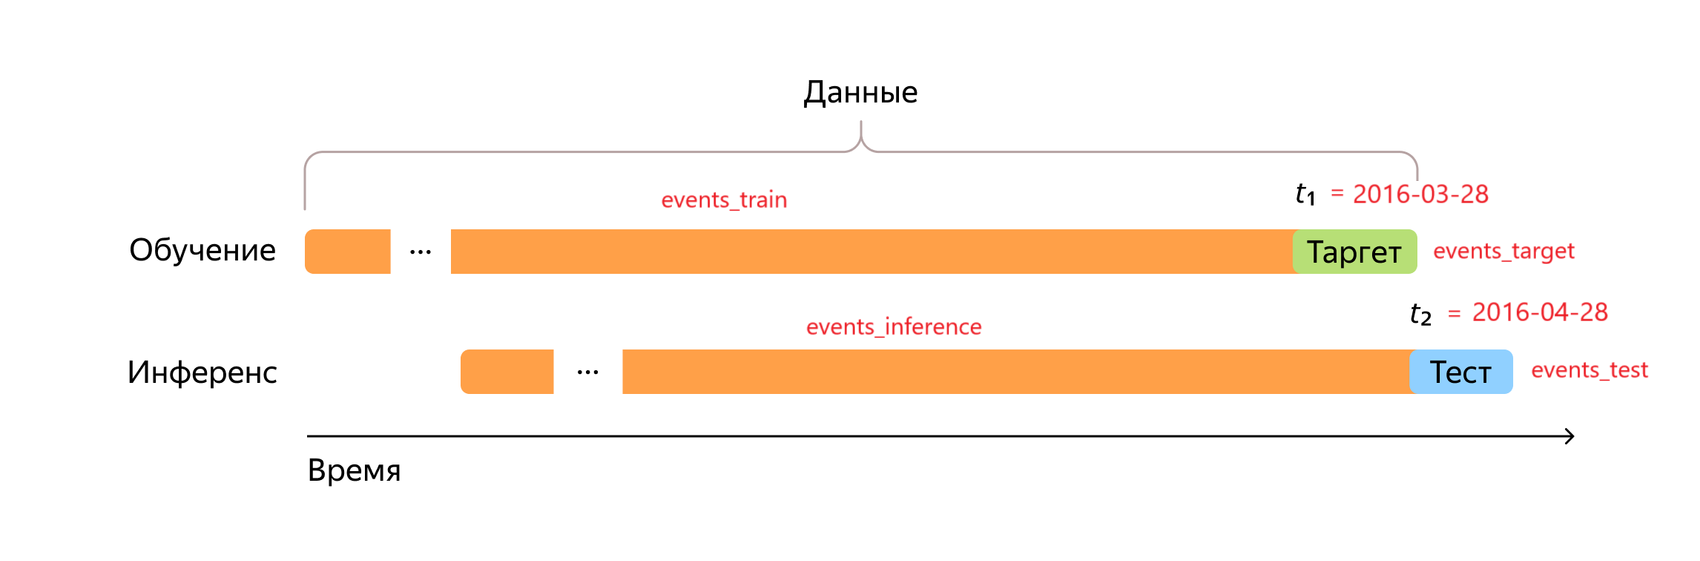

In [12]:
# Зададим точки разбиения
train_split_date = pd.to_datetime("2016-03-28")
test_split_date = pd.to_datetime("2016-04-28")

# Делим выборку на части
train_split_date_idx = prepared_df["fecha_dato"] <= train_split_date
target_split_date_idx = prepared_df["fecha_dato"].between(train_split_date, 
                                                          test_split_date,
                                                          inclusive='right')
test_split_date_idx = prepared_df["fecha_dato"] > test_split_date

train_df = prepared_df[train_split_date_idx]
target_df = prepared_df[target_split_date_idx]
inference_df = pd.concat([train_df, target_df])
test_df = prepared_df[test_split_date_idx]


In [13]:
print(train_df.shape[0] / prepared_df.shape[0])
print(target_df.shape[0] / prepared_df.shape[0])
print(inference_df.shape[0] / prepared_df.shape[0])
print(test_df.shape[0] / prepared_df.shape[0])

0.8637293989606303
0.06801883067203945
0.9317482296326697
0.0682517703673303


In [14]:
del prepared_df

<mark>Вывод.</mark> Выборка для обучения модели ранжирования содержит примерно 7% всех записей, тестовая - 7%. Сложно сказать, достаточые ли это объёмы. Необходимы дополнительные эксперименты.

# Кодирование user_id и item_id

In [ ]:
# Кодируем user_id в последовательность 0, 1, 2, ...
user_encoder_train = LabelEncoder()
user_encoder_train.fit(train_df["user_id"])
train_df["user_id_enc"] = user_encoder_train.transform(train_df["user_id"])

user_encoder_inference = LabelEncoder()
user_encoder_inference.fit(inference_df["user_id"])
inference_df["user_id_enc"] = user_encoder_inference.transform(inference_df["user_id"])

# Словарь для кодировки id клиентов: mapping user_id -> encoded value
# users_enc_dict = {user_id: encoded_value for user_id, encoded_value in zip(user_encoder.classes_, user_encoder.transform(user_encoder.classes_))}
# Словарь для раскодировки id клиентов: mapping encoded value -> user_id
# users_dec_dict = {value: key for key, value in users_enc_dict.items()}

# Кодируем user_id
# train_df["user_id_enc"] = train_df["user_id"].map(users_enc_dict)
# target_df["user_id_enc"] = target_df["user_id"].map(lambda x: users_enc_dict.get(x, -1)) # -1 для новых user_id
# test_df["user_id_enc"] = test_df["user_id"].map(lambda x: users_enc_dict.get(x, -1)) # -1 для новых user_id

In [14]:
# Словарь для кодировки id продуктов
items_enc_dict = {elem[1]:elem[0] for elem in enumerate(items_list)}

# Словарь для раскодировки id продуктов
items_dec_dict = {value: key for key, value in items_enc_dict.items()}

# Топ популярных объектов

Определим наиболее популярные банковские продукты, которые новые клиенты приобретают в 1-ю очередь после заключения договора банковского обслуживания.

In [ ]:
# Рассматриваемый период
print(inference_df['fecha_dato'].min() - pd.Timedelta('27days'))
print(test_split_date)

2015-01-01 00:00:00
2016-04-28 00:00:00


In [ ]:
# Шаг 1. Выделим клентов, заключивших договор с банком в рассматриваемый период.
# Шаг 2. Определим продукты, которые приобретены клиентами в 1-ю очередь.
# Шаг 3. Определим количество приобретённых в 1-ю очередь продуктов.
top_k_pop_items = (inference_df[inference_df['fecha_alta']
                   .between((inference_df['fecha_dato'].min() - pd.Timedelta('27days')),
                             test_split_date)]
                   .groupby('user_id_enc')[items_list]
                   .first()
                   .sum()
                   .sort_values(ascending=False))

In [ ]:
top_k_pop_items = (top_k_pop_items[top_k_pop_items > 0]
                   .astype("int")
                   .to_frame(name='count')
                   .reset_index(names='item_id')
                   )

In [40]:
# нормализация
scaler = MinMaxScaler()
top_k_pop_items['score'] = scaler.fit_transform(top_k_pop_items[['count']])

In [41]:
top_k_pop_items.head(10)

,item_id,count,score
0,ind_cco_fin_ult1,87948,1.000000
1,ind_ctma_fin_ult1,1977,0.022457
2,ind_deco_fin_ult1,1973,0.022411
3,ind_recibo_ult1,1145,0.012997
4,ind_cno_fin_ult1,799,0.009062
5,ind_nom_pens_ult1,717,0.008130
6,ind_nomina_ult1,701,0.007948
7,ind_ctju_fin_ult1,670,0.007596
8,ind_dela_fin_ult1,602,0.006822
9,ind_ecue_fin_ult1,118,0.001319


<mark>Вывод.</mark> Наиболее популярным продуктом, приобритаемым после заключения договора, является "Текущий счет" (ind_cco_fin_ult1). Следующим по популярности продуктами являются "Особый счёт 3" (ind_ctma_fin_ult1) и "Краткосрочный депозит" (ind_deco_fin_ult1).

In [ ]:
# Сохраним полученные объекты в файл
top_k_pop_items = top_k_pop_items[['item_id', 'score']]
top_k_pop_items.to_parquet('recommendations/top_popular.parquet')

# Получение рекомендаций с помощью ALS

## Рекомендации U2I

In [23]:
def als_model(events: pd.DataFrame, user_ids_encoded, user_encoder: LabelEncoder, file_model: str, file_rec: str):
    # ====== ОБУЧЕНИЕ МОДЕЛИ ==============
    # Создаём sparse-матрицу формата CSR 
    user_item_matrix = scipy.sparse.csr_matrix(events, dtype=np.int8)

    # Создаём модель рекомендаций
    model = AlternatingLeastSquares(factors=50, # количество латентных факторов
                                    iterations=25, 
                                    regularization=0.05, 
                                    random_state=0)
    model.fit(user_item_matrix) 

    # сохранение модели в файл
    with open(f'models/{file_model}.pkl', 'wb') as fd:
        joblib.dump(model, fd)
    
    print('Модель получена и сохранена!')
    
    # ====== ПОЛУЧЕНИЕ РЕКОМЕНДАЦИЙ ==============
    # получаем рекомендации для всех пользователей
    recom = model.recommend(
        user_ids_encoded, 
        user_item_matrix[user_ids_encoded], 
        filter_already_liked_items=False, # фильтровать уже понравившиеся элементы 
        N=5) # Получаем 5 рекомендаций для каждого клиента
    
    # преобразуем полученные рекомендации в табличный формат
    item_ids_enc = recom[0]
    als_scores = recom[1]

    recom = pd.DataFrame({
        "user_id_enc": user_ids_encoded,
        "item_id_enc": item_ids_enc.tolist(), 
        "score": als_scores.tolist()})
    # Метод explode() используется в Pandas для преобразования каждой строки, содержащей список или кортеж, в несколько строк.
    recom = recom.explode(["item_id_enc", "score"], ignore_index=True)

    # приводим типы данных
    recom["item_id_enc"] = recom["item_id_enc"].astype("int")
    recom["score"] = recom["score"].astype("float")

    # получаем изначальные идентификаторы
    recom["user_id"] = user_encoder.inverse_transform(recom["user_id_enc"])
    recom["item_id"] = recom["item_id_enc"].map(items_dec_dict)
    recom = recom.drop(columns=["user_id_enc", "item_id_enc"])

    # Сохраним полученные рекомендации в файл
    recom = recom[["user_id", "item_id", "score"]]
    recom.to_parquet(f"recommendations/{file_rec}.parquet")
    print('Рекомендации получены и сохранены!')
    pass

### Рекомендации U2I на данных events_train

In [ ]:
# Определим продукты, которые приобретены клиентами на момент обучения модели
u2i_train_df = train_df.groupby('user_id_enc')[items_list].sum()

In [25]:
u2i_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 947198 entries, 0 to 947197
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ind_ahor_fin_ult1  947198 non-null  int64  
 1   ind_aval_fin_ult1  947198 non-null  int64  
 2   ind_cco_fin_ult1   947198 non-null  int64  
 3   ind_cder_fin_ult1  947198 non-null  int64  
 4   ind_cno_fin_ult1   947198 non-null  int64  
 5   ind_ctju_fin_ult1  947198 non-null  int64  
 6   ind_ctma_fin_ult1  947198 non-null  int64  
 7   ind_ctop_fin_ult1  947198 non-null  int64  
 8   ind_ctpp_fin_ult1  947198 non-null  int64  
 9   ind_deco_fin_ult1  947198 non-null  int64  
 10  ind_deme_fin_ult1  947198 non-null  int64  
 11  ind_dela_fin_ult1  947198 non-null  int64  
 12  ind_ecue_fin_ult1  947198 non-null  int64  
 13  ind_fond_fin_ult1  947198 non-null  int64  
 14  ind_hip_fin_ult1   947198 non-null  int64  
 15  ind_plan_fin_ult1  947198 non-null  int64  
 16  ind_pre

In [26]:
# user_item_df = user_item_df.fillna(0)
u2i_train_df = u2i_train_df.astype("int")
u2i_train_df = u2i_train_df.rename(columns=items_enc_dict)
u2i_train_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
user_id_enc,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,15,0,0,0,0,0,15,0,0,0,0,0,0,0,0,0,7,15,0,0,0,0
1,0,0,0,0,15,0,0,0,15,0,0,0,15,0,0,15,0,0,15,0,0,15,15,15
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,10,0,5,0,0,0,0,0,0,13,15,0,0,0,0,15,15,15,0,0,0,15
4,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,15,0,0,0,0


In [27]:
u2i_train_df.mask(u2i_train_df > 0, 1, inplace=True)
u2i_train_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
user_id_enc,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,1
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,1,1,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0


In [28]:
u2i_train_df.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
user_id_enc,,,,,,,,,,,,,,,,,,,,,,,,
947193,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
947194,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
947195,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
947196,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
947197,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
# Подсчитываем количество строк, где сумма больше 0 (т.е., есть хотя бы одно значение 1)
count_null_rows = (u2i_train_df.sum(axis=1) > 0).sum()
print(count_null_rows)
print(u2i_train_df.shape[0])

724392
947198


In [30]:
# Получим рекомендации для всех имеющихся пользователей
als_model(u2i_train_df, u2i_train_df.index, user_encoder_train, 'als_model_train', 'als_rec_train')

  0%|          | 0/25 [00:00<?, ?it/s]

Модель получена и сохранена!
Рекомендации получены и сохранены!


### Рекомендации U2I на данных events_inference

In [ ]:
# Определим продукты, которые приобретены клиентами на момент обучения модели
u2i_inference_df = inference_df.groupby('user_id_enc')[items_list].sum()

In [32]:
u2i_inference_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 951952 entries, 0 to 951951
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ind_ahor_fin_ult1  951952 non-null  int64  
 1   ind_aval_fin_ult1  951952 non-null  int64  
 2   ind_cco_fin_ult1   951952 non-null  int64  
 3   ind_cder_fin_ult1  951952 non-null  int64  
 4   ind_cno_fin_ult1   951952 non-null  int64  
 5   ind_ctju_fin_ult1  951952 non-null  int64  
 6   ind_ctma_fin_ult1  951952 non-null  int64  
 7   ind_ctop_fin_ult1  951952 non-null  int64  
 8   ind_ctpp_fin_ult1  951952 non-null  int64  
 9   ind_deco_fin_ult1  951952 non-null  int64  
 10  ind_deme_fin_ult1  951952 non-null  int64  
 11  ind_dela_fin_ult1  951952 non-null  int64  
 12  ind_ecue_fin_ult1  951952 non-null  int64  
 13  ind_fond_fin_ult1  951952 non-null  int64  
 14  ind_hip_fin_ult1   951952 non-null  int64  
 15  ind_plan_fin_ult1  951952 non-null  int64  
 16  ind_pre

In [33]:
u2i_inference_df = u2i_inference_df.astype("int")
u2i_inference_df = u2i_inference_df.rename(columns=items_enc_dict)
u2i_inference_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
user_id_enc,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,16,0,0,0,0,0,16,0,0,0,0,0,0,0,0,0,7,16,0,0,0,0
1,0,0,0,0,16,0,0,0,16,0,0,0,16,0,0,16,0,0,16,0,0,16,16,16
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,11,0,5,0,0,0,0,0,0,14,16,0,0,0,0,16,16,16,0,0,0,16
4,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,16,0,0,0,0


In [34]:
u2i_inference_df.mask(u2i_inference_df > 0, 1, inplace=True)
u2i_inference_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
user_id_enc,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,1
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,1,1,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0


In [35]:
# Подсчитываем количество строк, где сумма больше 0 (т.е., есть хотя бы одно значение 1)
count_null_rows = (u2i_inference_df.sum(axis=1) > 0).sum()
print(count_null_rows)
print(u2i_inference_df.shape[0])

727848
951952


In [36]:
# Получим рекомендации для всех имеющихся пользователей
als_model(u2i_inference_df, u2i_inference_df.index, user_encoder_inference, 'als_model_inference', 'als_rec_inference')

  0%|          | 0/25 [00:00<?, ?it/s]

Модель получена и сохранена!
Рекомендации получены и сохранены!


## Рекомендации I2I на данных events_inference

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций. Возьмём простой алгоритм онлайн-рекомендаций, который будет использовать свойство похожести объектов (item2item similarity):
1. Есть заранее посчитанный набор похожих объектов, то есть для каждого объекта есть список объектов, которые на него похожи (в контексте поведения пользователей).
2. Для онлайн-взаимодействия пользователя с каким-либо объектом можно использовать список похожих на него объектов.
3. Теперь можно рекомендовать какие-то объекты (например, несколько первых) из списка. Это будут рекомендации, учитывающие последнее действие пользователя.

In [16]:
# загрузка модели, обученной на данных events_inference
with open('models/als_model_inference.pkl', 'rb') as fd:  # Открываем для чтения в бинарном формате
    als_model_inference = joblib.load(fd)  # Загружаем модель

In [ ]:
# получим энкодированные идентификаторы всех объектов, известных нам из events_inference
inference_item_ids_enc = inference_df['item_id_enc'].unique()

max_similar_items = 10

# получаем списки похожих объектов, используя ранее полученную ALS-модель
# метод similar_items возвращает и сам объект, как наиболее похожий
# этот объект позже уберём, но сейчас запросим на 1 больше
similar_items = als_model_inference.similar_items(inference_item_ids_enc, 
                                                  N=max_similar_items+1)

# преобразуем полученные списки в табличный формат
sim_item_item_ids_enc = similar_items[0]
sim_item_scores = similar_items[1]

In [24]:
# display(sim_item_item_ids_enc.tolist()[:2])
# display(sim_item_scores.tolist()[:2])

In [ ]:

similar_items = pd.DataFrame({
    "item_id_enc": inference_item_ids_enc,
    "sim_item_id_enc": sim_item_item_ids_enc.tolist(), 
    "score": sim_item_scores.tolist()})

# Метод explode() используется в Pandas для преобразования каждой строки, содержащей список или кортеж, в несколько строк.
similar_items = similar_items.explode(["sim_item_id_enc", "score"], ignore_index=True)

# приводим типы данных
similar_items["sim_item_id_enc"] = similar_items["sim_item_id_enc"].astype("int")
similar_items["score"] = similar_items["score"].astype("float")

# получаем изначальные идентификаторы
# столбец с ids книг
similar_items["item_id_1"] = item_encoder.inverse_transform(similar_items["item_id_enc"])
# столбец с ids похожих книг
similar_items["item_id_2"] = item_encoder.inverse_transform(similar_items["sim_item_id_enc"])
similar_items = similar_items.drop(columns=["item_id_enc", "sim_item_id_enc"])

# убираем пары с одинаковыми объектами
similar_items = similar_items.query("item_id_1 != item_id_2")

In [23]:
similar_items.head(10)

,score,item_id_1,item_id_2
1,0.936016,99262,99245
2,0.916691,99262,99257
3,0.915718,99262,99254
4,0.906596,99262,99241
5,0.901134,99262,99247
6,0.888419,99262,4637878
7,0.882680,99262,33882127
8,0.875734,99262,99261
9,0.873146,99262,695860
10,0.869926,99262,99239


In [ ]:
# Сохраним полученные рекомендации в файл
similar_items = similar_items[["item_id_1", "item_id_2", "score"]]
similar_items.to_parquet("prepared_data/similar.parquet")

# Добавление признаков

## Среднее количество прослушиваемых треков в день

In [16]:
def get_user_features(events):
    """ считает пользовательские признаки """
    
    user_features = events.groupby("user_id").agg(
        # длительность истории пользователя (в днях)
        days_count=("started_at", lambda x: (x.max()-x.min()).days),
        # количество треков, прослушанных за всё время
        track_count=("started_at", "count"),)
        
    # среднее количество прослушиваемых треков в день
    user_features["tracks_per_days"] = user_features["track_count"] / user_features["days_count"]
    
    return user_features.reset_index()


In [ ]:
user_features_for_train = get_user_features(train_df)
# user_features_for_inference = get_user_features(events_inference)

In [18]:
display(user_features_for_train.head())
# display(user_features_for_inference.head())

,user_id,days_count,track_count,tracks_per_days
0,0,60,26,0.433333
1,1,47,36,0.765957
2,2,137,14,0.102190
3,3,266,31,0.116541
4,4,245,231,0.942857


## Принадлежность трека к десяти популярным жанрам

Для экономии ресурсов возьмём не все жанры, а десять наиболее популярных. Все остальные отметим как не вошедшие в топ-10 и обозначим как others. 

In [19]:
item_genres_df = items.explode('genre')[['item_id', 'item_id_enc', 'genre']]
item_genres_df.head()

,item_id,item_id_enc,genre
0,26,0,pop
0,26,0,folk
1,38,1,pop
1,38,1,folk
2,135,2,pop


In [20]:
# Кодируем жанры
genre_encoder = LabelEncoder()
genre_encoder.fit(item_genres_df["genre"])
item_genres_df["genre_id_enc"] = genre_encoder.transform(item_genres_df["genre"])

In [21]:
item_genres_df.head()

,item_id,item_id_enc,genre,genre_id_enc
0,26,0,pop,91
0,26,0,folk,50
1,38,1,pop,91
1,38,1,folk,50
2,135,2,pop,91


In [ ]:
# Определим количество прослушиваний каждого трека
listen_count_df = train_df.groupby(by='item_id').agg(listen_count=("user_id", "count")).reset_index()
listen_count_df.head()

,item_id,listen_count
0,26,5
1,38,8
2,135,16
3,136,7
4,138,17


In [23]:
# Определим популярность жанров на основе количества прослушиваний соответствующих треков
listen_count_df = listen_count_df.merge(item_genres_df, 
                                        on='item_id', 
                                        how='left')
listen_count_df.head() 

,item_id,listen_count,item_id_enc,genre,genre_id_enc
0,26,5,0,pop,91
1,26,5,0,folk,50
2,38,8,1,pop,91
3,38,8,1,folk,50
4,135,16,2,pop,91


In [24]:
genres = listen_count_df.groupby(by=['genre', 'genre_id_enc'])['listen_count'].sum().reset_index()
genres.tail()

,genre,genre_id_enc,listen_count
138,ukrrock,138,696128
139,uzbekpop,139,92611
140,videogame,140,380706
141,vocal,141,190429
142,work,142,1962


In [25]:
# Для оценки популярности жанра используем относительное количество прослушиваний соответствующих треков
genres["score"] = genres["listen_count"] / genres["listen_count"].sum()
genres.sort_values(by="score", ascending=False).head(10)

,genre,genre_id_enc,listen_count,score
91,pop,91,46832583,0.147357
97,rap,97,31897633,0.100365
1,allrock,1,27786645,0.087430
110,ruspop,110,21228266,0.066794
111,rusrap,111,21071041,0.066299
39,electronics,39,17405759,0.054767
32,dance,32,13438514,0.042284
105,rock,105,11627561,0.036586
112,rusrock,112,11519141,0.036245
79,metal,79,11182402,0.035185


In [26]:
# Проверка
genres["score"].sum()

1.0

In [27]:
# Создаём sparse-матрицу формата CSR 
items_genres_matrix_train = scipy.sparse.csr_matrix((
    np.ones(len(item_genres_df), dtype=np.int8),  # значение 1 означает, что трек относится к жанру
    (item_genres_df['item_id_enc'], item_genres_df['genre_id_enc'])),
    dtype=np.int8)

In [28]:
# определяем индексы топ-10 жанров и всех остальных
genres_top_k = 10
genres_top_idx = genres.sort_values("score", ascending=False).head(genres_top_k).index
print(genres_top_idx)
# определяем индексы всех остальных жанров
genres_others_idx = list(set(genres.index) - set(genres_top_idx))

# определим имена столбцов, в которых будут содержаться метки о принадлежности трека к топ-10 жанрам
genres_top_columns = [f"genre_{id}" for id in genres_top_idx]
print(genres_top_columns)
# добавим имя столбца, в котором будет содержаться метка о принадлежности трека к остальным жанрам
genre_columns = genres_top_columns + ["genre_others"]

# составляем таблицу принадлежности книг к жанрам
item_features = (
    pd.concat([
        # топ-10 жанров
        pd.DataFrame(items_genres_matrix_train[:, genres_top_idx].toarray(), columns=genres_top_columns),
        # все остальные жанры
        pd.DataFrame(items_genres_matrix_train[:, genres_others_idx].sum(axis=1), columns=['genre_others'])
        ],
        axis=1)
    .reset_index()
    .rename(columns={"index": "item_id_enc"})
)

# заменяем количество других жанров меткой принадлежности трека к ним
item_features.loc[item_features['genre_others'] > 1, 'genre_others'] = 1
# объединяем информацию принадлежности книг к жанрам с основной информацией о книгах
item_features = items[['item_id', 'item_id_enc', 'album']].merge(item_features, on="item_id_enc", how="left")

# Добавляем парные признаки, по одному на каждый жанр, которые совместно показывают, какие жанры предпочитает пользователь.    
# user_genres_for_train = get_user_genres(events_train, items, genre_columns)
# candidates_for_train = candidates_for_train.merge(user_genres_for_train, on="user_id", how="left")

# user_genres_for_ranking = get_user_genres(events_inference, items, genre_columns)
# candidates_to_rank = candidates_to_rank.merge(user_genres_for_ranking, on="user_id", how="left")

Index([91, 97, 1, 110, 111, 39, 32, 105, 112, 79], dtype='int64')
['genre_91', 'genre_97', 'genre_1', 'genre_110', 'genre_111', 'genre_39', 'genre_32', 'genre_105', 'genre_112', 'genre_79']


In [29]:
display(item_features.head())

,item_id,item_id_enc,album,genre_91,genre_97,genre_1,genre_110,genre_111,genre_39,genre_32,genre_105,genre_112,genre_79,genre_others
0,26,0,[Taller Children],1,0,0,0,0,0,0,0,0,0,1
1,38,1,[Taller Children],1,0,0,0,0,0,0,0,0,0,1
2,135,2,[Wild Young Hearts],1,0,0,0,0,0,0,0,0,0,0
3,136,3,[Wild Young Hearts],1,0,0,0,0,0,0,0,0,0,0
4,138,4,"[Hits Of 2009, Clubland Classix, Don't Upset T...",1,0,0,0,0,0,0,0,0,0,0


In [30]:
# Проверка
item_features[item_features['genre_others']>1].shape[0]

0

## Количество альбомов, в которое вошла композиция

In [31]:
# Количество альбомов, в которое вошла композиция
item_features['album_count'] = item_features['album'].apply(len)

In [32]:
item_features.head()

,item_id,item_id_enc,album,genre_91,genre_97,genre_1,genre_110,genre_111,genre_39,genre_32,genre_105,genre_112,genre_79,genre_others,album_count
0,26,0,[Taller Children],1,0,0,0,0,0,0,0,0,0,1,1
1,38,1,[Taller Children],1,0,0,0,0,0,0,0,0,0,1,1
2,135,2,[Wild Young Hearts],1,0,0,0,0,0,0,0,0,0,0,1
3,136,3,[Wild Young Hearts],1,0,0,0,0,0,0,0,0,0,0,1
4,138,4,"[Hits Of 2009, Clubland Classix, Don't Upset T...",1,0,0,0,0,0,0,0,0,0,0,7


# Ранжирование рекомендаций

## Подготовка обучающей выборки

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

In [33]:
# Загрузка рекомендаций U2I, полученных на данных events_train
als_rec_train = pd.read_parquet("prepared_data/als_rec_train.parquet")
als_rec_train = als_rec_train.rename(columns={"score": "als_score"})

In [ ]:
# В кандидатах для обучения оставляем рекомендации тех пользователей, которые "присутствуют" в events_target.
candidates4train = als_rec_train[als_rec_train['user_id'].isin(target_df['user_id'].unique())]

In [35]:
print(candidates4train.shape[0])
display(candidates4train.head())

9087410


,user_id,item_id,als_score
30,3,35505245,0.425309
31,3,45499814,0.320505
32,3,33311009,0.304852
33,3,49961817,0.288387
34,3,39946957,0.262848


In [36]:
# Присоединяем признаки объектов
candidates4train = candidates4train.merge(item_features[['item_id', 'album_count'] + genre_columns],
                        on='item_id',
                        how='inner')

In [37]:
print(candidates4train.shape[0])

9087410


In [38]:
# Присоединяем признаки пользователей
candidates4train = candidates4train.merge(user_features_for_train[['user_id', 'tracks_per_days']],
                        on='user_id',
                        how='inner')

In [39]:
print(candidates4train.shape[0])

8611450


<mark>Вывод.</mark> После присоединения признаков пользователей объём выборки уменьшился, что говорит о наличии в events_target "холодных" пользователей. Проверим это.

In [ ]:
# Проверка
len(set(target_df['user_id']) - set(train_df['user_id']))

47596

In [ ]:
# Присоединяем свершившиеся события из events_target к прогнозируемым в candidates4train
target_df['target'] = 1
candidates4train = candidates4train.merge(target_df[['user_id', 'item_id', 'target']],
                        on=['user_id', 'item_id'],
                        how='left')
# Оставшимся событиям (рекомендациям) соответствует  target = 0
candidates4train['target'] = candidates4train['target'].fillna(0).astype("int")

In [42]:
print(candidates4train.shape[0])

8611450


In [43]:
# В кандидатах оставляем только тех пользователей, у которых есть хотя бы один положительный таргет.
# Для каждый группы строк (user_id) метод filter даёт значение True или False. В зависимости от этого группа отбрасывается или остаётся.
candidates4train = candidates4train.groupby("user_id").filter(lambda x: x["target"].sum() > 0)

In [44]:
print(candidates4train.shape[0])
print(candidates4train[candidates4train['target']==1].shape[0])
print(candidates4train[candidates4train['target']==0].shape[0])
print(candidates4train[candidates4train['target']==1].shape[0] / candidates4train.shape[0])

555650
69827
485823
0.12566723656978313


<mark>Вывод.</mark> В подготовленной выборе для обучения модели ранжирования наблюдается дисбаланс калссов: количество строк с target = 1 составляет около 13%. Необходимо это учесть при обучении модели.

In [45]:
candidates4train.head()

,user_id,item_id,als_score,album_count,genre_91,genre_97,genre_1,genre_110,genre_111,genre_39,genre_32,genre_105,genre_112,genre_79,genre_others,tracks_per_days,target
90,135,35505245,0.295316,1,0,1,0,0,1,0,0,0,0,0,0,9.784314,0
91,135,39632975,0.256553,1,0,0,1,0,0,0,0,0,1,0,0,9.784314,0
92,135,27032843,0.282170,3,0,0,0,0,0,0,0,0,0,1,1,9.784314,0
93,135,37258117,0.444965,2,0,0,0,0,0,0,0,0,0,0,1,9.784314,0
94,135,148092,0.286410,5,0,0,0,0,0,0,0,0,0,1,1,9.784314,0


## Обучение модели ранжирования

In [ ]:
# задаём имена колонок признаков и таргета
features = ['als_score', 'album_count'] + genre_columns
target = 'target'

# Create the Pool object
train_data = Pool(
    data=candidates4train[features], 
    label=candidates4train[target])

# инициализируем модель CatBoostClassifier
ranking_model = CatBoostClassifier(
    # Учтём дисбалан классов, придав событиям с target = 1 больший вес.
    auto_class_weights='Balanced', 
    iterations=500,
    learning_rate=0.1,
    depth=4,
    loss_function='Logloss',
    verbose=100,
    random_seed=0
)

# тренируем модель
ranking_model.fit(train_data)

0:	learn: 0.6911616	total: 133ms	remaining: 1m 6s
100:	learn: 0.6593524	total: 4.91s	remaining: 19.4s
200:	learn: 0.6501954	total: 9.27s	remaining: 13.8s
300:	learn: 0.6456860	total: 13.4s	remaining: 8.85s
400:	learn: 0.6424538	total: 17.5s	remaining: 4.32s
499:	learn: 0.6403376	total: 21.6s	remaining: 0us


In [ ]:
# сохранение модели в файл
os.makedirs('models', exist_ok=True)
with open(f'models/ranking_model.pkl', 'wb') as fd:
    joblib.dump(ranking_model, fd)

In [ ]:
del als_rec_train
del user_features_for_train
del candidates4train 

## Подготовка новых U2I рекомендаций

In [ ]:
del train_df
del target_df

In [32]:
# Загрузка рекомендаций U2I, полученных на данных events_inference
als_rec_inference = pd.read_parquet("prepared_data/als_rec_inference.parquet")
als_rec_inference = als_rec_inference.rename(columns={"score": "als_score"})

In [33]:
print(als_rec_inference.shape[0])

13732210


In [ ]:
# Обновляем значения пользовательских признаков
user_features_for_inference = get_user_features(inference_df)
display(user_features_for_inference.head())

,user_id,days_count,track_count,tracks_per_days
0,0,60,26,0.433333
1,1,47,36,0.765957
2,2,137,14,0.102190
3,3,312,32,0.102564
4,4,261,244,0.934866


In [ ]:
# Присоединяем значения пользовательских признаков
candidates4ranking = als_rec_inference.merge(user_features_for_inference[['user_id', 'tracks_per_days']],
                        on='user_id',
                        how='inner')

In [36]:
print(candidates4ranking.shape[0])

13425660


In [ ]:
# Присоединяем значения объектных признаков
candidates4ranking = candidates4ranking.merge(item_features[['item_id', 'album_count'] + genre_columns],
                        on='item_id',
                        how='inner')

In [40]:
print(candidates4ranking.shape[0])

13425660


## Ранжирование U2I рекомендаций (predict_proba)

In [36]:
# загрузка модели, обученной на данных events_inference
with open('models/ranking_model.pkl', 'rb') as fd:  # Открываем для чтения в бинарном формате
    ranking_model = joblib.load(fd)  # Загружаем модель

In [ ]:
# Получим топ-10 самых релевантных рекомендация для каждого пользователя, используя обученную модель.
features = ['als_score', 'album_count'] + genre_columns
inference_data = Pool(data=candidates4ranking[features])
predictions = ranking_model.predict_proba(inference_data)

candidates4ranking["ranking_score"] = predictions[:, 1]

# для каждого пользователя проставим rank, начиная с 1 — это максимальный ranking_score
candidates4ranking = candidates4ranking.sort_values(["user_id", "ranking_score"], ascending=[True, False])
candidates4ranking["rank"] = candidates4ranking.groupby("user_id").cumcount() + 1

In [42]:
candidates4ranking[['user_id', 'item_id', 'als_score', 'rank']].head(15)

,user_id,item_id,als_score,rank
7,0,27898772,0.009918,1
6,0,25903468,0.010450,2
2,0,27077792,0.011786,3
4,0,21101463,0.010511,4
8,0,34191851,0.009591,5
9,0,19799157,0.009523,6
5,0,19722850,0.010456,7
0,0,597196,0.014250,8
1,0,29213451,0.012668,9
3,0,18860,0.010714,10


In [ ]:
# Сохраним полученные рекомендации в файл
candidates4ranking = candidates4ranking[['user_id', 'item_id', 'rank']]
candidates4ranking.to_parquet("prepared_data/ranking.parquet")

# Оценка качества рекомендаций

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

## Загрузка рекомендаций

In [ ]:
top_k_rec = pd.read_parquet('prepared_data/top_popular.parquet')
top_k_rec = top_k_rec.head(10)

# Присоединяем топ-10 популярных треков к пользователям из events_test
top_k_rec['user_id'] = [test_df['user_id'].unique()] * top_k_rec.shape[0]
top_k_rec = top_k_rec.explode('user_id', ignore_index=True)

In [ ]:
# Проверка
print(len(test_df['user_id'].unique()))
print(top_k_rec.shape[0])

783525
7835250


In [15]:
als_rec_inference = pd.read_parquet("recommendations/als_rec_inference.parquet")
als_rec_inference = als_rec_inference.rename(columns={'als_score': 'score'})

In [106]:
als_rec_inference.shape[0]

4759760

In [17]:
old_users_set = set(inference_df['user_id']) & set(test_df['user_id'])
len(old_users_set)

926760

In [18]:
inference_df['fecha_dato'].max()

Timestamp('2016-04-28 00:00:00')

In [81]:
values4old_users = inference_df[(inference_df['fecha_dato']==inference_df['fecha_dato'].max()) &
                                 inference_df['user_id'].isin(test_df['user_id'])][['user_id', 'fecha_dato'] + items_list]

In [82]:
print(values4old_users.shape[0])

926663


In [83]:
values4old_users = pd.concat([values4old_users, 
                              test_df[test_df['user_id'].isin(values4old_users['user_id'])][['user_id', 'fecha_dato'] + items_list]])

In [84]:
print(values4old_users.shape[0])
display(values4old_users[values4old_users['user_id']==896839])

1853326


,user_id,fecha_dato,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
11787584,896839,2016-04-28,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
12849349,896839,2016-05-28,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0


In [85]:
values4old_users = values4old_users.sort_values(by=['user_id', 'fecha_dato'])

In [ ]:
# values4old_users = values4old_users.groupby(by='user_id')[items_list].diff()
values4old_users[items_list] = values4old_users.groupby(by='user_id')[items_list].diff()


In [93]:
values4old_users.dropna(inplace=True)

In [ ]:
print(values4old_users.isna().sum().sum())


0

In [104]:
# Выбираем строки, в которых хотя бы в одном из выбранных столбцов есть значение 1
print(values4old_users[values4old_users[items_list].isin([1]).any(axis=1)].shape[0])
print(values4old_users.shape[0])

27875
926663


In [105]:
27875 / 926663

0.030081054277552897

In [56]:
print(values4old_users.shape[0])
print(test_df.shape[0])

1853326
931453


In [ ]:
test_df[['user_id'] + items_list].merge(values4old_users, on='user_id', how='left', suffixes=('_inf', '_test'))

In [25]:
test_df['user_id'].nunique()

931453

In [17]:
ranking_rec = pd.read_parquet("prepared_data/ranking.parquet")
ranking_rec = ranking_rec.rename(columns={'rank': 'score'})

## Метрики классификации (Precision, Recall)

Посчитаем recall и precision для ALS-рекомендаций (als_recommendations). Для этого события в тестовой выборке и рекомендации для одних и тех же пользователей разметим признаками:
- gt (ground truth): объект есть в тестовой выборке;
- pr (predicted): объект есть в рекомендациях.

Теперь разметим признаки бинарной классификации:
- TP: объект есть и в тестовой выборке, и в рекомендациях (истинная рекомендация),
- FP: объекта нет в тестовой выборке, но он есть в рекомендациях (ложноположительная рекомендация),
- FN: объект есть в тестовой выборке, но его нет в рекомендациях (ложноотрицательная рекомендация)

In [18]:
def process_events_recs_for_binary_metrics(events_train, events_test, recs, top_k=None):

    """
    размечает пары <user_id, item_id> для общего множества пользователей признаками
    - gt (ground truth)
    - pr (prediction)
    top_k: расчёт ведётся только для top k-рекомендаций
    """

    # объект есть в тестовой выборке
    events_test["gt"] = True

    # валидацию проводим только для пользователей, представленных в тестовой выборке, исключая "холодных"
    common_users = set(events_test["user_id"]) & set(recs["user_id"])

    # print(f"Common users: {len(common_users)}")
    
    events_for_common_users = events_test[events_test["user_id"].isin(common_users)].copy()
    # оставляем только те item_id, которые были в events_train, 
    # т.к. модель ALS не может предсказать взаимодействие пользователя с новым объектом на основе скрытых групп-топиков, у него нет вектора-эмбеддинга
    events_for_common_users = events_for_common_users[events_for_common_users["item_id"].isin(events_train["item_id"].unique())]

    recs_for_common_users = recs[recs["user_id"].isin(common_users)].copy()
    recs_for_common_users = recs_for_common_users.sort_values(["user_id", "score"], ascending=[True, False])

    if top_k is not None:
        recs_for_common_users = recs_for_common_users.groupby("user_id").head(top_k)
    
    events_recs_common = events_for_common_users[["user_id", "item_id", "gt"]].merge(
        recs_for_common_users[["user_id", "item_id", "score"]], 
        on=["user_id", "item_id"], how="outer")    

    events_recs_common["gt"] = events_recs_common["gt"].fillna(False)
    # если в строке отсутствует "score", значит соответствующее событие отсутствует среди прогнозируемых, т.е. объект отсутствовал в рекомендациях top_k пользователя 
    events_recs_common["pr"] = ~events_recs_common["score"].isnull()
    
    events_recs_common["tp"] = events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fp"] = ~events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fn"] = events_recs_common["gt"] & ~events_recs_common["pr"]

    return events_recs_common

In [19]:
# код функции compute_cls_metrics для расчёта precision, recall
def compute_cls_metrics(events_recs_for_binary_metric):
    
    groupper = events_recs_for_binary_metric.groupby("user_id")

    # precision = tp / (tp + fp)
    precision = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fp"].sum())
    precision = precision.fillna(0).mean()
    
    # recall = tp / (tp + fn)
    recall = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fn"].sum())
    recall = recall.fillna(0).mean()

    return precision, recall

In [ ]:
for rec in (top_k_rec, als_rec_inference, ranking_rec):
    events_recs_for_binary_metrics = process_events_recs_for_binary_metrics(
        inference_df,
        test_df, 
        rec, 
        top_k=10)

    print(f'Precision@10, Recall@10: {compute_cls_metrics(events_recs_for_binary_metrics)}\n')

Precision@10, Recall@10: (0.003782266041287768, 0.002933246289506794)

Precision@10, Recall@10: (0.007416866085957693, 0.011976694087914424)

Precision@10, Recall@10: (0.007718729661163282, 0.012464313872558542)



<mark>Вывод.</mark> Использование персональных и ранжированных рекомендаций улучшает метрики precision, recall, но они всё равно имеют очень маленькие значения. За такой результат ML-инженера можно увольнять.

## Покрытие (Coverage)

Рекомендательная система может выдавать точные рекомендации, но только для небольшого подмножества объектов или подмножества пользователей. Формально метрики будут иметь высокие значения, а фактически рекомендации будут малоценными для большинства пользователей. Чтобы оценить рекомендации по этому фактору, используют метрику «покрытие» (англ. Coverage), которая отвечает на вопрос, насколько полно объекты (items) или пользователи (users) покрыты рекомендациями.

In [21]:
# расчёт покрытия по объектам
for rec in (top_k_rec, als_rec_inference, ranking_rec):
    cov_items = len(set(rec['item_id']) & set(items['item_id'])) / len(set(items['item_id']))
    print(f'Coverage@10: {cov_items}\n')

Coverage@10: 1e-05

Coverage@10: 0.003258

Coverage@10: 0.003248



<mark>Вывод.</mark> Рекомендации топ-10 популярных треков для всех пользователей дают "покрытие", близкое к нулю, что ожидаемо.

## Новизна (Novelty)

В простом случае новизну можно оценить как долю объектов, ранее не виденных пользователем, среди топ-k рекомендованных.

In [22]:
del events_train
del events_target

In [ ]:
print(inference_df.shape[0])
print(als_rec_inference.shape[0])

208731252
13732210


In [ ]:
# Оставляем только тех пользователей, что есть в тестовой выборке, для экономии ресурсов. В противном случае "ядро" завершает работу с ошибкой
common_users = set(test_df["user_id"]) & set(inference_df["user_id"])

In [ ]:
inference_df = inference_df[inference_df['user_id'].isin(common_users)]
# Создаем столбец is_listen
inference_df['is_listen'] = True
inference_df.shape[0]

127365961

In [ ]:
for rec in (top_k_rec, als_rec_inference, ranking_rec):
    rec = rec[rec['user_id'].isin(common_users)]

    rec = rec.merge(inference_df[['user_id', 'item_id', 'is_listen']], on=['user_id', 'item_id'], how='left')
    rec['is_listen'] = rec['is_listen'].fillna(False).astype('bool')

    # проставим ранги
    rec = rec.sort_values(['user_id', 'score'], ascending=[True, False])
    rec['rank'] = rec.groupby('user_id').cumcount() + 1

    # посчитаем Novelty по пользователям
    novelty_5 = (1-rec.query('rank <= 5').groupby('user_id')['is_listen'].mean())
    # TODO Посчитать не удалось из-за нехватки вычислительных ресурсов
    # novelty_10 = (1-rec.groupby('user_id')['is_listen'].mean())

    # посчитаем средний Novelty
    print(f'Novelty@5: {novelty_5.mean()}')

Novelty@5: 0.9234986119781633
Novelty@5: 0.6232061312045905
Novelty@5: 0.6697392644148392


In [ ]:
for rec in (top_k_rec, als_rec_inference, ranking_rec):
    rec = rec[rec['user_id'].isin(common_users)]

    rec = rec.merge(inference_df[['user_id', 'item_id', 'is_listen']], on=['user_id', 'item_id'], how='left')
    rec['is_listen'] = rec['is_listen'].fillna(False).astype('bool')

    # проставим ранги
    rec = rec.sort_values(['user_id', 'score'], ascending=[True, False])
    # rec['rank'] = rec.groupby('user_id').cumcount() + 1

    # посчитаем Novelty по пользователям
    # novelty_5 = (1-rec.query('rank <= 5').groupby('user_id')['is_listen'].mean())
    # TODO Посчитать не удалось из-за нехватки вычислительных ресурсов
    novelty_10 = (1-rec['is_listen'].mean())

    # посчитаем средний Novelty
    # print(f'Novelty@10: {novelty_5.mean()}')
    print(f'Novelty@10: {novelty_10}')

Novelty@10: 0.9306120578585945
Novelty@10: 0.6760273353965491
Novelty@10: 0.6760273353965491


<mark>Вывод.</mark> Несмотря на популярность композиций из списков топ-5 и топ-10, отдельно взятые пользователи с ними "слабо" взаимодействовали. Об этом говорят соответствующие высокие значения Novelty@5 и Novelty@10 на уровне 92...93%.

# Сохранение рекомендаций

In [5]:
# Пути для копирования
file_path = 'prepared_data/'
object_key = 'recsys/recommendations/'

# В описании проекта есть требования к названию файлов, сохраняемых в хранилище S3. Придётся использовать словарь соответствия имён.
files_name_dict = {
                   'top_popular.parquet': 'top_popular.parquet',
                   'als_rec_inference.parquet': 'personal_als.parquet',
                   'similar.parquet': 'similar.parquet',
                   'ranking.parquet': 'recommendations.parquet'
                   }

# Создаем клиент S3 с кастомным endpoint
s3_client = boto3.client(
    's3',
    endpoint_url=endpoint_url,
    # region_name='ru-central1',  # можно указать регион, если нужно
    aws_access_key_id=os.environ.get('AWS_ACCESS_KEY_ID'),
    aws_secret_access_key=os.environ.get('AWS_SECRET_ACCESS_KEY'),
)

# Загрузка файла
for files in files_name_dict.items():
    try:
        s3_client.upload_file((file_path + files[0]), bucket_name, (object_key + files[1]))
        print(f"Файл {files[0]} успешно загружен в {url}/{object_key}")

    except Exception as e:
        print(f"Произошла ошибка при загрузке файла: {e}")

Файл top_popular.parquet успешно загружен в s3://s3-student-mle-20250226-e7b4c7010d/recsys/recommendations/
Файл als_rec_inference.parquet успешно загружен в s3://s3-student-mle-20250226-e7b4c7010d/recsys/recommendations/
Файл similar.parquet успешно загружен в s3://s3-student-mle-20250226-e7b4c7010d/recsys/recommendations/
Файл ranking.parquet успешно загружен в s3://s3-student-mle-20250226-e7b4c7010d/recsys/recommendations/


# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.
1. Использование персональных и ранжированных рекомендаций улучшает метрики precision, recall, но они всё равно имеют очень маленькие значения (около 1%). За такой результат ML-инженера можно увольнять. Возможно, допущены ошибки в коде.
2. Рекомендации топ-10 популярных треков для всех пользователей дают "покрытие", близкое к нулю, что ожидаемо. Персональные рекомендации "покрывают" всего 0,3% всех композиций.
3. Несмотря на популярность композиций из списков топ-5 и топ-10, отдельно взятые пользователи с ними "слабо" взаимодействовали. Об этом говорят соответствующие высокие значения Novelty@5 и Novelty@10 на уровне 92...93%.

 # Эксперименты

In [5]:
# Получаем переменные окружения
endpoint_url = os.environ.get('ENDPOINT_URL')  # https://storage.yandexcloud.net
bucket_name = os.environ.get('S3_BUCKET_NAME')  # s3-student-mle-20250226-e7b4c7010d
url = f's3://{bucket_name}'
aws_access_key_id = os.environ.get('AWS_ACCESS_KEY_ID')
aws_secret_access_key = os.environ.get('AWS_SECRET_ACCESS_KEY')

# Укажите путь к файлу Parquet в S3
s3_path = f'{url}/recsys/recommendations/top_popular.parquet'  # Замените на путь к вашему файлу внутри бакета

# Читаем файл Parquet из S3 с помощью pandas
try:
    df = pd.read_parquet(s3_path, storage_options={
        'key': aws_access_key_id,
        'secret': aws_secret_access_key,
        'client_kwargs': {'endpoint_url': endpoint_url}
    })
    print("Файл успешно загружен из S3!")
    display(df.head())  # Выводим первые несколько строк DataFrame

except Exception as e:
    print(f"Произошла ошибка при загрузке файла из S3: {e}")


Файл успешно загружен из S3!


,item_id,score
0,53404,1.000000
1,33311009,0.918655
2,178529,0.916746
3,35505245,0.868185
4,24692821,0.764844


In [8]:
import boto3
print(f"boto3 version: {boto3.__version__}")
import botocore
print(f"botocore version: {botocore.__version__}")
import aiobotocore
print(f"aiobotocore version: {aiobotocore.__version__}")
import pandas
print(f"pandas version: {pandas.__version__}")
import s3fs
print(f"s3fs version: {s3fs.__version__}")



boto3 version: 1.38.27
botocore version: 1.38.27
aiobotocore version: 2.23.0
pandas version: 2.1.1
s3fs version: 2025.5.1


In [ ]:
test_df.head(20)

,user_id,item_id,started_at
32,3,78194999,2022-12-20
244,4,83375862,2022-12-18
245,4,83764704,2022-12-18
246,4,83858540,2022-12-20
247,4,84099295,2022-12-21
248,4,84487963,2022-12-23
249,4,86153070,2022-12-23
250,4,86836928,2022-12-26
251,4,87446393,2022-12-26
252,4,91718971,2022-12-28
